In [1]:
import numpy as np
import pandas as pd
import random

from pathlib import Path
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.metrics import AUC
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, GRU, Input, BatchNormalization, Dropout
from ncps.wirings import AutoNCP
from ncps.keras import LTC

2025-04-03 14:57:45.343317: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-03 14:57:45.398620: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-03 14:57:45.479081: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743681465.533943  945027 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743681465.546621  945027 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-03 14:57:45.669573: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

# Configuration

In [8]:
NUM_EPOCHS = 100
NUM_EXPERIMENTS = 1

def create_model(train):
    model = Sequential()
    model.add(Input(shape=(train.shape[1], train.shape[2])))

    model.add(Dropout(0.2))
    model.add(GRU(20, return_sequences=True, activation='tanh'))

    model.add(Dropout(0.2))
    model.add(GRU(20, return_sequences=True, activation='tanh'))

    model.add(Dropout(0.2))
    model.add(GRU(10, return_sequences=True, activation='tanh'))

    model.add(Dropout(0.2))
    model.add(GRU(10, return_sequences=False, activation='tanh'))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=0.002, weight_decay=1e-7, use_ema=True), loss='binary_crossentropy', metrics=["accuracy", AUC(name="auc")])
    return model

# Experiment

In [3]:
ID = ["ID"]
USER = ["SubjectID"]
IDS = ["SubjectID", "VideoID"]
TARGET = ["predefinedlabel"]
FEATURES = ["Delta", "Theta", "Alpha1", "Alpha2", "Beta1", "Beta2", "Gamma1", "Gamma2"]
LAGS = [1]
INIT_SEED = 5412

In [4]:
data_dir = Path("/home/aseliverstov/projects/brain_signals/data")
data = pd.read_csv(data_dir / "EEG_data.csv")

new_features = []
for lag in LAGS:
    for feature_name in FEATURES:
        new_feature_name = f"{feature_name}_{lag}"
        new_features.append(new_feature_name)
        data[new_feature_name] = data.groupby(IDS)[feature_name].shift(lag).fillna(0)
FEATURES.extend(new_features)

data["ID"] = (len(np.unique(data["VideoID"])) * data["SubjectID"] + data["VideoID"]).astype("int")
data = data[ID + USER + FEATURES + TARGET]

data.head(3)

,ID,SubjectID,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,Delta_1,Theta_1,Alpha1_1,Alpha2_1,Beta1_1,Beta2_1,Gamma1_1,Gamma2_1,predefinedlabel
0,0,0.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,0.0
2,0,0.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,0.0


In [5]:
def reshape_dataset(data):
    features = []
    target = []
    for cur_id in np.unique(data[ID].to_numpy()):
        cur_id_data = data[data[ID].to_numpy() == cur_id]
        target.append(np.mean(cur_id_data[TARGET].to_numpy()).astype("int"))
        features.append(cur_id_data[FEATURES].to_numpy())

    features = pad_sequences(features)
    return np.array(features), np.array(target)

def pad_sequences(arrays, pad_value=0):
    max_length = max(arr.shape[0] for arr in arrays)
    padded_arrays = [
        np.pad(
            arr,
            ((0, max_length - arr.shape[0]), (0, 0)),
            mode='constant',
            constant_values=pad_value)
            for arr in arrays
        ]
    return np.stack(padded_arrays)

In [6]:
X, _ = reshape_dataset(data)
model = create_model(X)
model.summary()

2025-04-03 14:57:49.956403: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout (Dropout)               │ (None, 144, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 144, 20)        │         2,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 144, 20)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 144, 20)        │         2,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 144, 20)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 144, 10)        │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 144, 10)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 10)             │           660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,431 (25.12 KB)

 Trainable params: 6,431 (25.12 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
%%time

all_acc = []
all_loss = []
all_auc = []

all_val_acc = []
all_val_loss = []
all_val_auc = []

for j, seed in tqdm(enumerate(np.arange(NUM_EXPERIMENTS) + INIT_SEED)):
    np.random.seed(int(seed))
    random.seed(int(seed))
    tf.random.set_seed(int(seed))

    train_id = np.random.choice(np.unique(np.ravel(data[USER])), 7, replace=False)
    train_index = np.isin(data[USER], train_id)

    train = data.iloc[train_index]
    test = data.iloc[~train_index]

    X_train, y_train = reshape_dataset(train)
    X_test, y_test = reshape_dataset(test)

    y_train = y_train.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)

    model = create_model(X_train)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=NUM_EPOCHS,
        batch_size=10,
        verbose=1,
    )

    acc = history.history['accuracy']
    loss = history.history['loss']
    auc = history.history['auc']

    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    val_auc = history.history['val_auc']

    all_acc.append(acc)
    all_loss.append(loss)
    all_auc.append(auc)

    all_val_acc.append(val_acc)
    all_val_loss.append(val_loss)
    all_val_auc.append(val_auc)

epoch_acc = np.mean(all_acc, axis=0)
epoch_loss = np.mean(all_loss, axis=0)
epoch_auc = np.mean(all_auc, axis=0)

epoch_val_acc = np.mean(all_val_acc, axis=0)
epoch_val_loss = np.mean(all_val_loss, axis=0)
epoch_val_auc = np.mean(all_val_auc, axis=0)

0it [00:00, ?it/s]

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 221ms/step - accuracy: 0.5938 - auc: 0.5414 - loss: 0.6890 - val_accuracy: 0.7667 - val_auc: 0.8089 - val_loss: 0.6401
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.7558 - auc: 0.7352 - loss: 0.6435 - val_accuracy: 0.8333 - val_auc: 0.8000 - val_loss: 0.5844
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 0.7341 - auc: 0.7931 - loss: 0.6101 - val_accuracy: 0.8333 - val_auc: 0.7356 - val_loss: 0.5284
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.7341 - auc: 0.6771 - loss: 0.5784 - val_accuracy: 0.8333 - val_auc: 0.7467 - val_loss: 0.4807
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.7341 - auc: 0.8174 - loss: 0.5344 - val_accuracy: 0.8333 - val_auc: 0.8000 - val_loss: 0.4525
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.7558 - auc: 0.6895 - loss: 0.5425 - val_accuracy: 0.8333 - val_auc: 0.7889 - val_loss: 0.4403
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/

1it [01:43, 103.40s/it]

CPU times: user 3min 43s, sys: 1min 37s, total: 5min 20s
Wall time: 1min 43s


In [10]:
for i in range(NUM_EPOCHS):
    print(f"Epoch {(i + 1)}: TRAIN Accuracy = {np.round(epoch_acc[i], 3)} Loss = {np.round(epoch_loss[i], 3)} AUC = {np.round(epoch_auc[i], 3)}")
    print(f"Epoch {(i + 1)}: VAL Accuracy = {np.round(epoch_val_acc[i], 3)} Loss = {np.round(epoch_val_loss[i], 3)} AUC = {np.round(epoch_val_auc[i], 3)}")

Epoch 1: TRAIN Accuracy = 0.629 Loss = 0.684 AUC = 0.597
Epoch 1: VAL Accuracy = 0.767 Loss = 0.64 AUC = 0.809
Epoch 2: TRAIN Accuracy = 0.786 Loss = 0.624 AUC = 0.785
Epoch 2: VAL Accuracy = 0.833 Loss = 0.584 AUC = 0.8
Epoch 3: TRAIN Accuracy = 0.771 Loss = 0.585 AUC = 0.773
Epoch 3: VAL Accuracy = 0.833 Loss = 0.528 AUC = 0.736
Epoch 4: TRAIN Accuracy = 0.771 Loss = 0.542 AUC = 0.777
Epoch 4: VAL Accuracy = 0.833 Loss = 0.481 AUC = 0.747
Epoch 5: TRAIN Accuracy = 0.771 Loss = 0.5 AUC = 0.813
Epoch 5: VAL Accuracy = 0.833 Loss = 0.452 AUC = 0.8
Epoch 6: TRAIN Accuracy = 0.786 Loss = 0.506 AUC = 0.726
Epoch 6: VAL Accuracy = 0.833 Loss = 0.44 AUC = 0.789
Epoch 7: TRAIN Accuracy = 0.786 Loss = 0.495 AUC = 0.757
Epoch 7: VAL Accuracy = 0.833 Loss = 0.431 AUC = 0.789
Epoch 8: TRAIN Accuracy = 0.786 Loss = 0.464 AUC = 0.838
Epoch 8: VAL Accuracy = 0.833 Loss = 0.425 AUC = 0.811
Epoch 9: TRAIN Accuracy = 0.8 Loss = 0.466 AUC = 0.829
Epoch 9: VAL Accuracy = 0.833 Loss = 0.418 AUC = 0.833
Ep

In [43]:
a = np.random.randint(3, size=(3, 4))
print(a)
print("-----")
b = np.roll(a, 1, axis=0)
b[0, :] = 0
print(b)


[[0 1 1 0]
 [0 2 2 1]
 [0 2 2 2]]
-----
[[0 0 0 0]
 [0 1 1 0]
 [0 2 2 1]]


In [44]:
import numpy as np
import shap
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.lines as mlines

def plot_time_series_with_shap(model, X_train, X_test, y_test, j, feature_names, lags=None):
    X_sample, y_sample = X_test[j], y_test[j]
    background = X_train

    explainer = shap.GradientExplainer(model, background)
    shap_values = explainer.shap_values(np.expand_dims(X_sample, axis=0))[0]
    shap_values = np.squeeze(shap_values)

    num_features = len(feature_names)
    if lags is not None:
        num_features = int(num_features / (1 + len(lags)))
        shap_values = shap_values.reshape(-1, 1 + len(lags), num_features)

        for k, lag in enumerate(lags):
            shap_values[:, k + 1, :] = np.roll(shap_values[:, k + 1, :], shift=lag, axis=0)
            shap_values[:lag, k + 1, :] = 0
        shap_values = np.sum(shap_values, axis=1)

    shap_mean = np.mean(shap_values)

    plt.figure(figsize=(15, 8))
    red_colors = cm.Reds(np.linspace(0.2, 0.9, num_features))  # More color variation in red
    blue_colors = cm.Blues(np.linspace(0.2, 0.9, num_features))  # More color variation in blue
    
    scatter_plots = []
    for i in range(num_features):
        cur_feature_shap_values = shap_values[:, i] / shap_mean
        ts = np.arange(X_sample.shape[0])
        c = [red_colors[i] if el > 0 else blue_colors[i] for el in cur_feature_shap_values]
        s = [2 * np.abs(el) if 2 * np.abs(el) > 0.5 else 0.5 for el in cur_feature_shap_values]
        
        plt.scatter(ts, X_sample[:, i], color=c, s=s)
        scatter_plots.append((red_colors[i], blue_colors[i], feature_names[i]))
    
    raw_prediction = model.predict(np.expand_dims(X_sample, axis=0))
    prediction = 'Confused' if raw_prediction > 0.5 else 'Not Confused'
    plt.yscale('log')
    plt.xlabel("Timestep")
    plt.ylabel("Feature Value (Log Scale)")
    
    # Custom legend with both blueish and reddish markers
    legend_handles = [
        mlines.Line2D([0], [0], marker='o', color='w', markerfacecolor=red, markersize=5, label=name)
        for red, blue, name in scatter_plots
    ] + [
        mlines.Line2D([0], [0], marker='o', color='w', markerfacecolor=blue, markersize=5)
        for _, blue, _ in scatter_plots
    ]
    legend_labels = [name for _, _, name in scatter_plots] + ["" for _ in scatter_plots]
    
    plt.legend(handles=legend_handles, labels=legend_labels, loc="upper right", ncol=2, handletextpad=1.5)
    plt.title(f"Sample {j}. True value '{'Confused' if y_sample == 1 else 'Not Confused'}'. Predicted '{prediction}': {np.round(raw_prediction, 2)}%")
    plt.show()

/home/aseliverstov/.cache/pypoetry/virtualenvs/brain-signals-_5HxkjSc-py3.10/lib/python3.10/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_138
Received: inputs=['Tensor(shape=(1, 144, 16))']
  warnings.warn(msg)
/home/aseliverstov/.cache/pypoetry/virtualenvs/brain-signals-_5HxkjSc-py3.10/lib/python3.10/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_138
Received: inputs=['Tensor(shape=(50, 144, 16))']
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


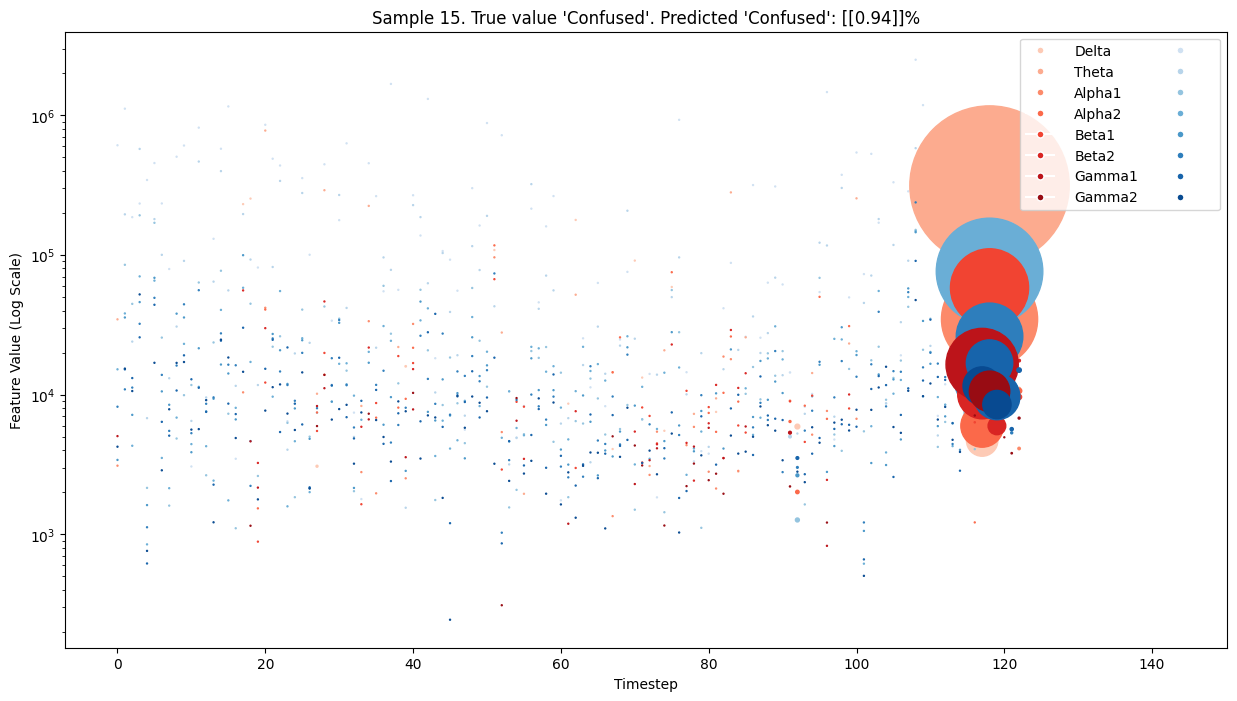

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


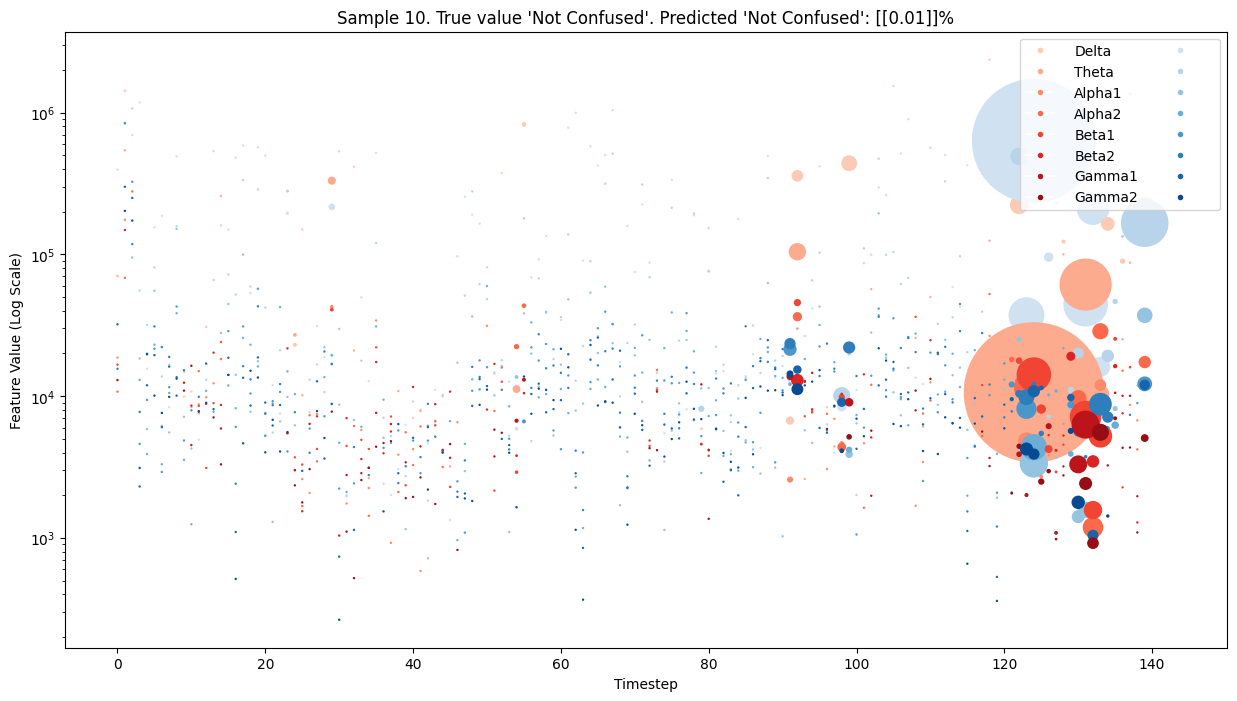

In [45]:
plot_time_series_with_shap(model, X_train, X_test, y_test, 15, FEATURES, LAGS)
plot_time_series_with_shap(model, X_train, X_test, y_test, 10, FEATURES, LAGS)